In [168]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from experiments.SL_bound import *
from experiments.DA_bound import *
from bounds.bounds import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
task = 2

results_folder = "/cephyr/users/frejohk/Alvis/projects/mnist_transfer/results/task2/Binary"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
r_files = [f for f in os.listdir(results_folder) if 'results.pkl' in f]

D = pd.DataFrame({})
for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0)

D['germain_bound'] = np.nan
D['beta_bound'] = np.nan

In [175]:
m_bound = D['m_bound'].values[0]
delta = D['delta'].values[0]
    
 # calculate disrho bound
for s in np.sort(D['sigma'].unique()):
    stratum = D['sigma']==s
    train_germain = D[stratum]['train_germain'].values
    e_s = D[stratum]['e_s'].values
    e_t = D[stratum]['e_t'].values
    d_tx = D[stratum]['d_tx'].values
    d_sx = D[stratum]['d_sx'].values
    KL = D[stratum]['KL'].values

    res, bestparam, boundparts = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL))

    # calculate beta bound
    [res2, bestparam2, boundparts2] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL),beta_bound=True)            
    
    I = D['sigma'] == s
    D.loc[I,'germain_bound'] = res
    D.loc[I,'beta_bound'] = res2
    

Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....


,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,alpha,sigma,epsilon,checkpoint,delta,m_bound,m_target,seed,germain_bound,beta_bound
0,0,0.078133,0.175100,0.000000,0.074299,0.169057,0.012086,0.007669,0.002574,0.004041,...,0.1,0.003,0.01,1_0,0.05,63009,69990,None,0.165389,0.919886
0,0,0.131507,0.228063,0.000000,0.060898,0.134895,0.186337,0.141220,0.054885,0.062384,...,0.1,0.030,0.01,1_0,0.05,63009,69990,None,0.241710,1.145097
0,0,0.079809,0.179177,0.000000,0.066027,0.156128,0.046098,0.027564,0.008069,0.016420,...,0.1,0.010,0.01,1_0,0.05,63009,69990,None,0.172909,0.896215
0,45,0.124714,0.201562,0.558201,0.044413,0.092126,0.218873,0.160602,0.036521,0.046046,...,0.1,0.030,0.01,1_45,0.05,63009,69990,None,0.234939,0.892921
0,45,0.062783,0.143875,5.582011,0.059142,0.137207,0.013336,0.007281,0.000885,0.003791,...,0.1,0.003,0.01,1_45,0.05,63009,69990,None,0.144410,0.748138


Sigma = 0.00300


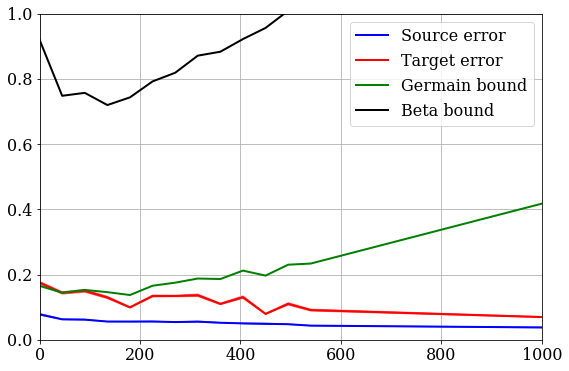

Sigma = 0.01000


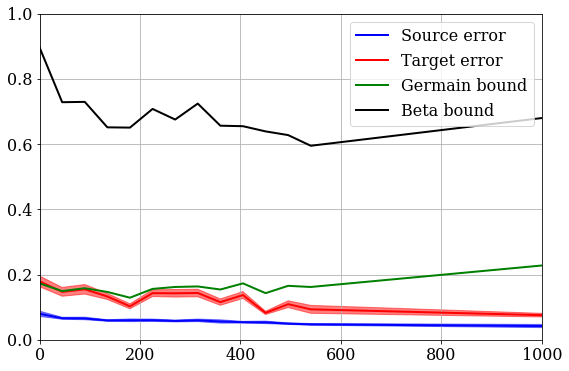

Sigma = 0.03000


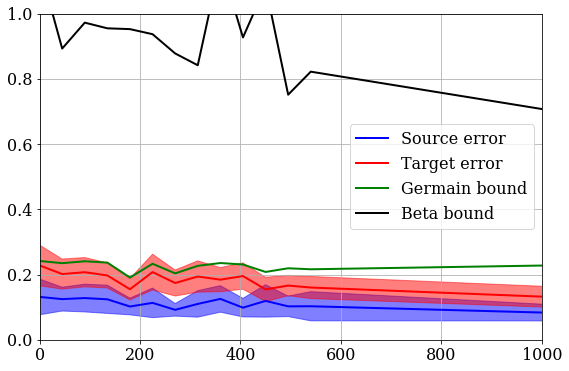

In [180]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for s in np.sort(D['sigma'].unique()):
    print('Sigma = %.5f' % s)
    plt.figure(figsize=(9,6))
    plt.grid(zorder=-100)
    
    stratum = D['sigma']==s
    ws = D[stratum]['Weightupdates']
    e_so = D[stratum]['train_germain']
    e_ta = D[stratum]['target_germain']
    e_so_std = D[stratum]['error_std']
    e_ta_std = D[stratum]['target_error_std']
    KL = D[stratum]['KL']
    gb = D[stratum]['germain_bound']
    bb = D[stratum]['beta_bound']       

        
    plt.plot(ws, e_so, label='Source error', lw=2, c='b')
    plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')
    
    plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
    plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')
    
    plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
    plt.plot(ws, bb, label='Beta bound', lw=2, c='k')
    
    plt.xlim(0, 1000)
    plt.ylim(0, 1.)
    
    plt.legend()
    plt.show()